<a href="https://colab.research.google.com/github/twisha-k/Python_notes/blob/main/144_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 144: Hyperspectral Image Classification

---

#### Teacher-Student Activities

In the previous classes, we explored satellite data obtained from Landsat-8 and Sentinel-2 satellites which possess 7 and 12 spectral bands respectively. However, you may need to process certain satellite images containing more than 100 spectral bands. Such satellite images are referred as [**Hyperspectral Images (HSI)**](https://en.wikipedia.org/wiki/Hyperspectral_imaging).

In this lesson, we will load and process HSI by performing dimensionality reduction using PCA (Principal Component Analysis). We will also implement kNN algorithm to perform HSI classification.

Before that, let us explore HSI in more detail.


---

#### Understanding Hyperspectral Images (HSI)

- In Remote Sensing, **Hyperspectral** remote sensors are used for monitoring the earth's surface with high spectral resolution.
- Hyperspectral sensors acquire imagery in hundreds of spectral bands, thereby providing valuable information to identify features on the Earth's surface.

- These images are useful for detection and identification of minerals, terrestial vegetation, and man-made materials and backgrounds.

It is difficult to obtain HSI, however there are some publicly available HSI datasets in [Grupo De Inteligencia Computacional](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) that can be used for HSI analysis. All of them are Earth observation images taken from airbornes or satellites.  

In this lesson, we will use **Pavia University** public HSI dataset. Features of this dataset are as follows:
- Acquired by the ROSIS sensor during a flight campaign over Pavia, northern Italy.
- Number of spectral bands: 103
- Size: $610 \times 340$ pixels
- It also consists of ground truth data having **9 classes** which are as follows:

<center> <img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/dedef169-6f5c-400c-b42c-4cb788b5725e.PNG"/>

  `Table 1: Groundtruth classes for the Pavia University scene and their respective samples number` </center>

**Dataset Source:** http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

  

---

#### Activity 1: Downloading Dataset

Let us first download both the datasets (`.mat` files), one containing the hyperspectral scene data and other provides the ground truth details of that  HSI image.



In [ ]:
# Run the code cell below to download both the dataset.
! wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
! wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2024-06-06 06:41:01--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2024-06-06 06:41:02--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M  8.81MB/s    in 4.1s    

2024-06-06 06:41:06 (8.19 MB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2024-06-06 06:41:06--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.2

You can see the downloaded files by opening the Files section on the left hand side of your colab file.

<img src ="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/2d7e036e-a644-46a2-beed-90c4f5cb529a.PNG"/>

In the previous class, we learned how to import and read a `.mat` file using `loadmat()` function of ` scipy.io` module. Let us first load the HSI image `PaviaU.mat` in a variable `pavia_db`.

In [ ]:
# S1.1: Load 'PaviaU.mat' using `scipy.io.loadmat()` function. Print the obtained result and its type.
from scipy.io import loadmat
pavia_db=loadmat('/content/PaviaU.mat')
print(type(pavia_db))


<class 'dict'>


In [ ]:
pavia_db

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:21:46 2011',
 '__version__': '1.0',
 '__globals__': [],
 'paviaU': array([[[ 647,  499,  464, ..., 3221, 3238, 3250],
         [ 604,  546,  527, ..., 2442, 2464, 2528],
         [ 621,  746,  556, ..., 2308, 2345, 2361],
         ...,
         [ 524,  525,  598, ..., 2936, 2940, 2950],
         [ 528,  330,   70, ..., 2737, 2774, 2829],
         [ 711,  483,  423, ..., 2562, 2539, 2488]],
 
        [[ 705,  681,  668, ..., 2607, 2607, 2609],
         [ 891,  692,  453, ..., 1581, 1561, 1522],
         [ 547,  511,  604, ..., 1535, 1531, 1538],
         ...,
         [1149,  658,  434, ..., 3247, 3251, 3277],
         [ 917, 1004,  743, ..., 2828, 2806, 2808],
         [1037,  849,  547, ..., 2491, 2527, 2522]],
 
        [[1084,  875,  706, ..., 2108, 2167, 2183],
         [ 335,  517,  611, ..., 1105, 1109, 1095],
         [1042,  683,  318, ...,  806,  791,  814],
         ...,
         [ 799,  693,  

Here, you can observe that the `loadmat()` returns a dictionary object. This dictionary contains a numpy array whose key is `paviaU` and its values contains pixel values.

Let us store the value of key `paviaU` in a variable `X_data` and print its shape.

In [ ]:
# S1.2: Obtain the HSI pixel values stored as an array in the above dictionary.
# Print the shape of the obtained array
x_data=pavia_db['paviaU']
print(x_data.shape)
x_data

(610, 340, 103)


array([[[ 647,  499,  464, ..., 3221, 3238, 3250],
        [ 604,  546,  527, ..., 2442, 2464, 2528],
        [ 621,  746,  556, ..., 2308, 2345, 2361],
        ...,
        [ 524,  525,  598, ..., 2936, 2940, 2950],
        [ 528,  330,   70, ..., 2737, 2774, 2829],
        [ 711,  483,  423, ..., 2562, 2539, 2488]],

       [[ 705,  681,  668, ..., 2607, 2607, 2609],
        [ 891,  692,  453, ..., 1581, 1561, 1522],
        [ 547,  511,  604, ..., 1535, 1531, 1538],
        ...,
        [1149,  658,  434, ..., 3247, 3251, 3277],
        [ 917, 1004,  743, ..., 2828, 2806, 2808],
        [1037,  849,  547, ..., 2491, 2527, 2522]],

       [[1084,  875,  706, ..., 2108, 2167, 2183],
        [ 335,  517,  611, ..., 1105, 1109, 1095],
        [1042,  683,  318, ...,  806,  791,  814],
        ...,
        [ 799,  693,  481, ..., 2761, 2791, 2842],
        [ 226,  350,  613, ..., 2885, 2879, 2859],
        [ 828,  571,  479, ..., 2799, 2809, 2806]],

       ...,

       [[ 733,  617,  70

Observe the shape of HSI image i.e. `(610, 340, 103)`. This indicates there are 103 spectral bands, each band having 610 rows and 340 columns.

Similarly, load the `PaviaU_gt.mat` file that contains the ground truth classes. This ground truth data will be used to train the classifier as it yields the actual information from the surface. Hence, this will correspond to the target label for our classifier model.

In [ ]:
# S1.3: Obtain the Ground Truth for the Pavia university area under study using 'loadmat()' function.
grd_tr=loadmat('/content/PaviaU_gt.mat')
print(type(grd_tr))
grd_tr

<class 'dict'>


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:25:52 2011',
 '__version__': '1.0',
 '__globals__': [],
 'paviaU_gt': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)}

The `loadmat()` function returned a dictionary that contains a key `paviaU_gt` whose values are the class label of every pixel in an image that was captured using the hyperspectral sensors. Let us first obtain these classes in a variable `y_data`.

(610, 340)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)
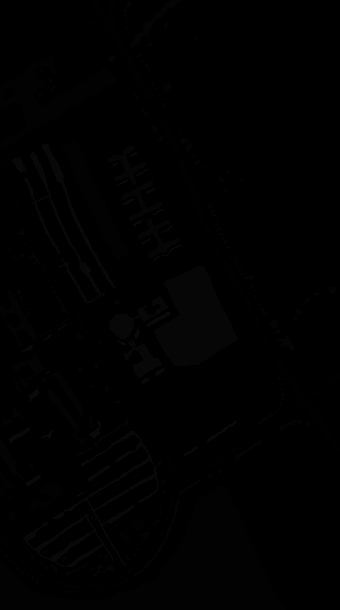

In [ ]:
# S1.4: Obtain the class labels of ground truth information into an array.
y_data=grd_tr['paviaU_gt']
print(y_data.shape)
y_data

You may observe that there are some samples whose class label is `0` which may indicate discarded or unidentified samples. You can remove these samples if you need to perform detailed HSI image analysis. For now, we will keep these samples as we will perform dimensionality reduction and classification on these datasets.

Let us now visualise few spectral bands from the Pavia University HSI.

---

#### Activity 2: Plotting bands

The number of spectral bands for Pavia University Dataset is 103. Plotting all the 103 spectral bands would not be feasible. So, let us plot only few bands of the HSI using `imshow()` function of `matplotlib.pyplot` module.

To plot band 0, pass `X_data[:, :, 0]` as input to the `imshow()` function. Also, pass `cmap = 'cubehelix'` to set colours for the colormap.

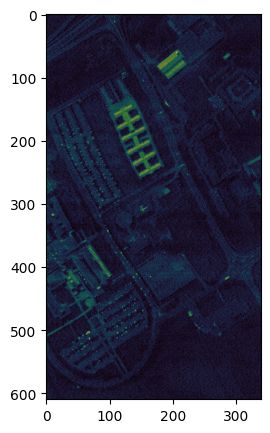

In [ ]:
# S2.1: Plot band 0
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.imshow(x_data[:,:,0],cmap = 'cubehelix')
plt.show()

Similarly, plot the last band 102 using the `imshow()` function.  

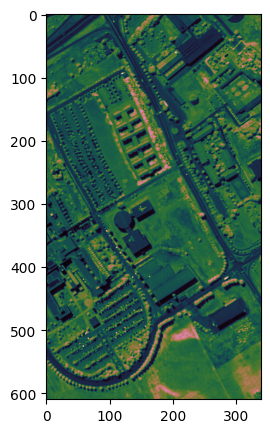

In [ ]:
# S2.2: Plot band 102
plt.figure(figsize=(10,5))
plt.imshow(x_data[:,:,102],cmap = 'cubehelix')
plt.show()

Similarly, let us also visualise ground truth HSI stored in `y_data` variable to get an image for the ground truth.

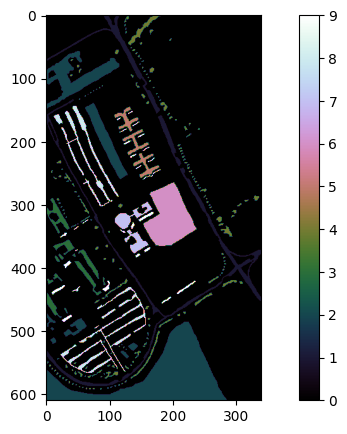

In [ ]:
# T2.1: Visualize the Ground Truth and add colorbar to the image using 'colorbar()' function.
plt.figure(figsize=(10,5))
plt.imshow(y_data,cmap = 'cubehelix')
plt.colorbar()
plt.show()

Observe the colours associated with every class label. Recall the ground truth classes given in Table 1.

<center> <img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/dedef169-6f5c-400c-b42c-4cb788b5725e.PNG"/>
</center>




Referring to the `Table 1` and ground truth image, we can say that:
1. The pixels in black (class `0`) are unclassified pixel values.
2. Majority portions in HSI image are occupied by class `1` (`Asphalt`) and class `2` (`Meadows`). This is also evident by looking at the number of samples in both the classes (Refer Table `1`).
3. The white coloured objects in image indicates `Shadows` and occupy least area in ground truth image.


Now that we have visualised the spectral bands and the ground truth data, let us now reduce the dimensions of Pavia University HSI.

---

#### Activity 3: Reducing Dimensions using PCA

Let us first obtain a DataFrame containing both the features `X_data` as well as the target variable `y_data`. Before that, print the shapes of both feature variable and target variable.

In [ ]:
# S3.1: Print the shapes of feature and target variable.
print(x_data.shape,y_data.shape)

(610, 340, 103) (610, 340)


To combine `X_data` and `y_data` into a single DataFrame, `X_data` must be a two dimensional array. Let us convert the three-dimensional array `X_data` into a two-dimensional array using `reshape()` function.

In [ ]:
# T3.1: Convert X_data into a 2D array to create a DataFrame.
x_reshape=x_data.reshape(-1,x_data.shape[2])
print(x_reshape.shape)
x_reshape

(207400, 103)


array([[ 647,  499,  464, ..., 3221, 3238, 3250],
       [ 604,  546,  527, ..., 2442, 2464, 2528],
       [ 621,  746,  556, ..., 2308, 2345, 2361],
       ...,
       [ 593,  387,  428, ..., 2382, 2407, 2423],
       [ 593,  751,  655, ..., 2312, 2308, 2289],
       [ 889,  720,  449, ..., 2416, 2447, 2485]], dtype=uint16)

In [ ]:
610*340

207400

Let us store the above 2D array as a DataFrame `df` with column names labeled as `Band 1`, `Band 2` and so on, till `Band 102`.

In [ ]:
# S3.2: Convert the above 2D array into a DataFrame.
import pandas as pd
df=pd.DataFrame(x_reshape,columns=[f'band{i}'for i in range(1,104)])
df.head()


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103
0,647,499,464,371,291,319,365,322,296,305,...,3420,3416,3335,3256,3226,3205,3210,3221,3238,3250
1,604,546,527,455,378,377,336,314,324,329,...,2605,2583,2538,2509,2511,2501,2468,2442,2464,2528
2,621,746,556,360,285,300,274,276,332,319,...,2282,2288,2242,2193,2202,2225,2266,2308,2345,2361
3,637,592,482,556,508,284,178,198,193,224,...,2684,2675,2609,2541,2551,2571,2569,2573,2620,2644
4,625,560,480,360,377,341,264,208,231,266,...,2423,2392,2344,2289,2328,2415,2424,2386,2431,2456


Hence, we obtain a DataFrame containing the 103 feature variables. Let us now concat the `y_data` variable as target variable in the above DataFrame. For this, flatten the 2D array `y_data` using `ravel()` function and add it as a column `class` to the above DataFrame.

In [ ]:
# S3.3: Add the target variable 'y_data' as a column to the DataFrame 'df'
df['target']=y_data.ravel()
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,target
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [ ]:
df.shape

(207400, 104)

Thus, the HSI DataFrame consists of 103 feature variables representing 103 spectral bands and a target variable indicating the class label given to each pixel value.

If we deploy any classification algorithm on this high-dimensional dataset, a lot of computational power and time would be needed to process such dataset. Thus, to reduce the dimensions of this 103-dimensional dataset, let us use a dimensionality reduction technique called **PCA** (Principal Component Analysis).

Before that, we need to identify how many dimensions should we reduce to retain at least 90% of the information or variance in the reduced dataset.

**Applying PCA:**

Recall that in `sklearn` PCA, we can use the following attributes  with the `PCA` object (for instance, `pca_obj`):

- `pca_obj.explained_variance_`: To determine the amount of variance or information explained by each of the components.
- `pca_obj.explained_variance_ratio_:`  To determine the percentage of variance explained by each of the components.

Use the `explained_variance_ratio_` attribute to determine the percentage of variance explained by first 50 components (There are total 103 components). For this,
1. Pass `n_components = 50` to the `PCA` constructor.
2. Call the `fit_transform()` function on the PCA object and pass the feature dataset `df.iloc[:, :-1]` as input to this function.



In [ ]:
# S3.4: Determine explained_variance_ratio of 50 PCs.
import numpy as np
from sklearn.decomposition import PCA
pca_ob=PCA(n_components=50)
pca_50=pca_ob.fit_transform(df.iloc[:,:-1])
np.round(pca_ob.explained_variance_ratio_,3)

array([0.583, 0.361, 0.044, 0.003, 0.002, 0.002, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

In the above output, you can observe that first principal component explains approx $58.3\%$ of variance, second component explains approx $36.1\%$ of variance and so on. Thus, first 2 components explains approx $94.4\%$ ($58.3\%$ + $36.1\%$) of variance.

Let us calculate the cumulative variance of 50 principal components using cumulative sum function `cumsum()` of `numpy` module.


In [ ]:
# S3.5: Calculate cumulative explained variance ratio
cu_exp_vr=np.cumsum(pca_ob.explained_variance_ratio_)
cu_exp_vr

array([0.58318064, 0.94418758, 0.98856319, 0.99157161, 0.99366953,
       0.99544696, 0.99667817, 0.99736012, 0.99782334, 0.99814674,
       0.99839249, 0.99858239, 0.9987283 , 0.99885381, 0.99895203,
       0.9990384 , 0.99911431, 0.99918768, 0.9992491 , 0.99930553,
       0.99935427, 0.99940021, 0.99944281, 0.99948078, 0.99951661,
       0.99954616, 0.99957387, 0.99960045, 0.99962348, 0.99964485,
       0.99966572, 0.99968509, 0.9997036 , 0.9997207 , 0.99973677,
       0.99975267, 0.99976761, 0.99978213, 0.99979599, 0.99980853,
       0.99982029, 0.99983141, 0.99984204, 0.99985244, 0.99986192,
       0.99987103, 0.99987968, 0.99988795, 0.99989579, 0.99990293])

Thus, first 2 components hold approx $94.4\%$ of variance, first 3 components hold approx $98.8\%$ variance and so on.

Let us visualise the above cumulative sum of variances for all 50 principal components by creating a line plot.


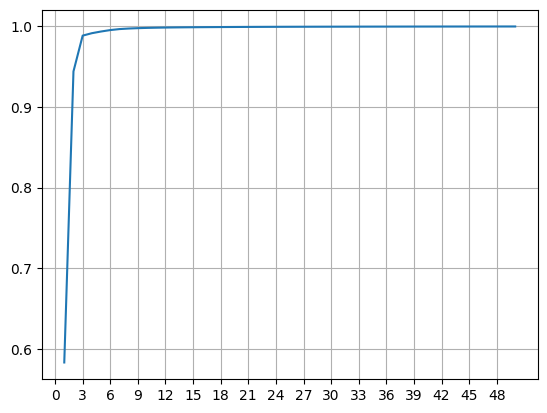

In [ ]:
# S3.6: Create a line plot with components on x-axis and their cumulative sum on y-axis.
plt.plot(np.arange(1,51,),cu_exp_vr)
plt.grid()
plt.xticks(range(0,51,3))
plt.show()

In the above graph, we can observe that  approximately 99%  of variance is obtained at `n_components = 3`. This means that if we reduce our 103-dimensional dataset into 3 dimensions, it would retain approximately  99%  of the information.


Thus, let us now apply `sklearn` PCA on the feature variables  and reduce it to 3 dimensions using the steps given below:

1. Import `PCA` from `sklearn.decomposition` module.
2. Pass the number of components/dimensions to the PCA constructor using the following syntax:

  **Syntax of PCA:** `PCA(n_components = None)`

  Where, `n_components` is the number of components to keep. As we are projecting the dataset into  3 dimensions, `n_components` would be `3` in this case. Also, pass `random_state = 42` to obtain same result on every execution.

3. Call the `fit_transform()` function on PCA object to obtain the new set of features or principal components.

4. Convert the array obtained after applying `fit_transform()` function to a DataFrame.

In [ ]:
# S3.7: Reduce the number of features from 103 to 3 using PCA.
pca_ob2=PCA(n_components=3)
pca_3=pca_ob2.fit_transform(df.iloc[:,:-1])
#np.round(pca_ob2.explained_variance_ratio_,3)
pca_3

array([[-5150.19004357,  6795.05276995,  1532.35146075],
       [-6082.24576002,  3158.59219488,  1463.19474351],
       [-7214.50540528,  1158.87581214,  1400.81789859],
       ...,
       [-3975.03508407,  1643.062559  ,   253.13217783],
       [-4042.63945154,  1231.52037702,   499.96031433],
       [-4086.61575576,  2180.66762844,   454.93327522]])

Thus, we have reduced the number of features from 103 to 3 by using PCA thereby retaining approx $99\%$ of information.

Let us store the above 3D array into a DataFrame and concat the class labels stored in `y_data` to this DataFrame.

In [ ]:
# T3.2: Obtain the PCA reduced DataFrame containing only 3 features and target variable.
pca_df=pd.concat([pd.DataFrame(pca_3),pd.DataFrame(y_data.ravel())],axis=1)
pca_df.columns=[f'pca{i}'for i in range(1,4)]+['target']
pca_df.head()



,pca1,pca2,pca3,target
0,-5150.190044,6795.052770,1532.351461,0
1,-6082.245760,3158.592195,1463.194744,0
2,-7214.505405,1158.875812,1400.817899,0
3,-6566.279360,3398.894763,1126.024772,0
4,-6496.967970,2154.797771,1035.954575,0


Thus, we have reduced our dataset from 103 spectral bands to only 3 spectral band. Let us plot these 3 spectral bands using the step given below:

1. Create a figure object using `figure()` function of `matplotlib.pyplot` module. Pass `figsize = (20, 10)` as input to this function.

2. Initiate a `for` loop whose iterator `i` ranges from `1` to `4`. Inside this `for` loop,
  - Call `add_subplot(1, 3, i)` function to add a subplot axes at `i` position in a figure of 1 row and 3 columns.
  - Call `imshow()` function of  `matplotlib.pyplot` module and pass following inputs:
      - `pca_df.loc[:, f'PC-{i}'].values.reshape(610, 340)`: Each column of `pca_df` DataFrame. Also, `reshape(610, 340)` function is applied to get an image of the same size as that of the original HSI data.
      - `cmap = 'cubehelix'`: To set the colours for the colormap.
  - Add title to each spectral band using `title()` function of `matplotlib.pyplot` module.

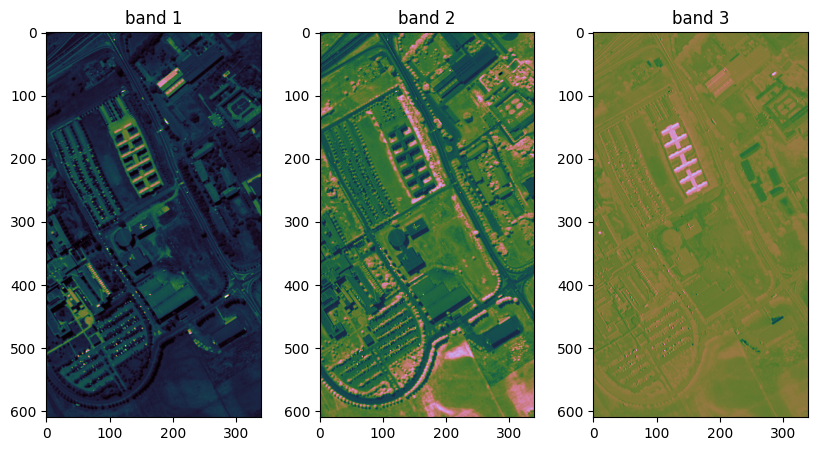

In [ ]:
# T3.3: Plot the PCA reduced spectral bands.
fig=plt.figure(figsize=(10,5))
for i in range(1,4):
  fig.add_subplot(1,3,i)
  plt.imshow(pca_df.loc[:, f'pca{i}'].values.reshape(610, 340),cmap='cubehelix')
  plt.title(f'band {i}')

Now that we have obtained reduced set of features, let us build a classification model using these reduced features and evaluate the performance of this model.

---

#### Activity 4: Classification Using PCA Reduced Features

The classification of HSI implies classifying  class label of every pixel in an image that was captured using the hyperspectral sensors.

For our dataset, the `pca_df` DataFrame contains 3 feature variables and a target variable `class`.

Let's normalise the features using `StandardScaler` technique.



In [ ]:
# S4.1: Normalise the features using 'StandardScaler'
from sklearn.preprocessing import StandardScaler


# Obtain features from 'pca_df'
features=pca_df.iloc[:,:-1]
std_scl=StandardScaler()
scl_data=std_scl.fit_transform(features)
scl_fea=pd.DataFrame(scl_data,columns=features.columns)
scl_fea


# Define StandardScaler object


# Apply fit and transform operation using 'fit_transform()'

# Create a new DataFrame for scaled features


,pca1,pca2,pca3
0,-0.920136,1.542998,0.992468
1,-1.086658,0.717243,0.947677
2,-1.288948,0.263154,0.907277
3,-1.173136,0.771810,0.729300
4,-1.160752,0.489304,0.670964
...,...,...,...
207395,-0.770977,0.047432,-0.024353
207396,-0.716875,0.155604,0.129101
207397,-0.710182,0.373101,0.163948
207398,-0.722261,0.279650,0.323813


In [ ]:
pca_df.head()

,pca1,pca2,pca3,target
0,-5150.190044,6795.052770,1532.351461,0
1,-6082.245760,3158.592195,1463.194744,0
2,-7214.505405,1158.875812,1400.817899,0
3,-6566.279360,3398.894763,1126.024772,0
4,-6496.967970,2154.797771,1035.954575,0


Let us split the DataFrames into train and test sets for building a classification model using `train_test_split()` function. Here, the scaled feature variables are stored in `feature_scaled` variable, target variable is stored in `pca_df['class']` column.

Also, as this is a multi-class classification problem, set `stratify =  pca_df['class']` inside `train_test_split()` function to obtain a balanced train/test dataset consisting of samples from each target label.

In [ ]:
# S4.2: Perform the train-test split
from sklearn.model_selection import train_test_split

# Print the shape of train and test sets.
x_train,x_test,y_train,y_test=train_test_split(scl_fea,pca_df['target'],test_size=0.3,stratify = pca_df['target'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(145180, 3)
(62220, 3)
(145180,)
(62220,)


Let's build kNN classifier model for $k=7$ using the steps given below:

1. Import the `KNeighborsClassifier` class from the `sklearn.neighbors` module.

2. Create an object of this class using the following syntax:

  `KNeighborsClassifier(n_neighbors)`
  
  Where,
  - `n_neighbors` is basically the value for the $k$. The optimal value of `k` here comes at `k = 7`. (It takes around 30 minutes to run the elbow test due to the complexity of the dataset).

3. Call the `fit()` function using the classifier object and pass the train set as inputs to this function.

4. Call the `score()` function  using the classifier object  and pass the train set as inputs to determine the train set accuracy of the model.

5. Also, determine the accuracy score of the test set using the `score()` function.

In [ ]:
# S4.3: Build kNN classifier model.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# kNN Classifier
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
# Call the 'score()' function to check the accuracy score of the train set and test set.
print(knn.score(x_train,y_train))
print(knn.score(x_test,y_test))

0.8346535335445654
0.7946640951462552


Here, we observe that the classifier is able to correctly classify the land cover with an accuracy score of approximately 80% for the test dataset. Let us obtain the classification report to get the details of classifier performance.

In [ ]:
# S4.4: Obtain Classification report
from sklearn.metrics import classification_report
knn_pred=knn.predict(x_test)
print(classification_report(y_test,knn_pred))


              precision    recall  f1-score   support

           0       0.83      0.93      0.88     49387
           1       0.50      0.31      0.38      1989
           2       0.44      0.27      0.33      5595
           3       0.31      0.11      0.17       630
           4       0.45      0.11      0.18       919
           5       0.77      0.86      0.81       403
           6       0.31      0.04      0.07      1509
           7       0.61      0.50      0.55       399
           8       0.46      0.31      0.37      1105
           9       0.57      0.35      0.43       284

    accuracy                           0.79     62220
   macro avg       0.53      0.38      0.42     62220
weighted avg       0.76      0.79      0.77     62220



The classification report yields good classifier performance with good f1-score for all the class labels, except for class `6`.


<br>

Next, let's obtain a plot for the HSI pixel values predicted by the `kNN` classifier. For this, use the `imshow()` function and pass the following parameters as input to this function:

  - The data that will be obtained from the classifier as: `knn.predict(features_scaled)`.

  - Apply `reshape(610, 340)` to get an image of the same size as of the ground truth data.

  - `cmap = 'cubehelix'`: To set colours for the colormap.
  

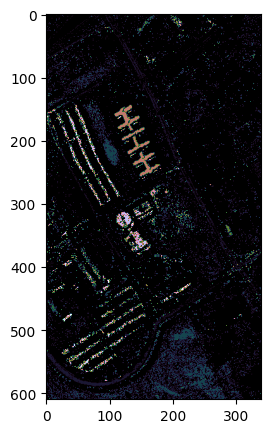

In [ ]:
# S4.5: Visualise predicted values obtained from classification of HSI.
plt.figure(figsize=(10,5))
plt.imshow(knn.predict(scl_fea).reshape(610, 340),cmap = 'cubehelix')

Let's compare the image obtained from classifier prediction with the images from the ground truth data.

<center><img src=https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/465394f5-341f-4467-a7e4-a90355a56f80.png></center>

<br>

In the image comparison we observe that there are certain differences between the classifier prediction and the ground truth since the accuracy is around 80% only. You can apply other classification algorithms such as Support Vector Machine and Random Forest Classifier to further improve the accuracy scores.

---

<br>

We will stop here. Congratulations you have completed 144 classes of this curriculum.

Thank you for choosing us to introduce you with the fascinating world of Machine Learning:

Hope we had a highly impactful learning journey together for the last 144 classes. To recap the learning objectives and the knowedge you have acquired, here is a recap of journey from 1 to 144 classes:

- **Lessons 1 to 29:**
  - Basic Python programming
  - Identifying Exoplanets
  - Analysing Historical Meteorite Landings

- **Lessons 30 to 57:**
  - Python data structures
  - Data Processing and Visualisation
  - Correlation and Probability
  - Central Limit Theorem
  - Object Oriented Programming


- **Lessons 58 to 81:** Equipped with sufficient knowledge in Python and Data Analytics we dived into the world of *Supervised* machine learning algorithms like Linear Regression and Support Vector Machines.


- **Lessons 82 to 91:** We expanded our skills in supervised learning with hands on Support Vector Machines for next few lessons.

- **Lessons 92 to 97:**  We learned to built apps on *Streamlit* platform which enables us to connect the world of mobile apps to practical machine learning algorithms.

- **Lesson 98 to 106:** We explored algorithms such as *Decision Trees* and *Polynomial Regression* which enables us to handle highly complicated real-world problems.

- **Lesson 107 to 120:** Another subset of machine learning is in the form of *Unsupervised* machine learning algorithms. We explored the most useful unsupervised techniques:

 - Clustering and its application to some real-word problems.

 - PCA and its application in dimensionality reduction.

-  **Lesson 121 to 126:** Coming back to supervised learning we explored a mathematically intensive but highly useful algorithms like Naive Bayes and kNN.

- **Lesson 127 to 132:** Diving deep into the depths of applied machine learning, we further explored *Time-Series* datasets and prediction algorithms such as ARIMA and SARIMA which are the kind of algorithms which social media uses to rate the trending posts or understand the consumer behavior.

- **Lesson 133 to 136:** We explored *Recommender Systems* which are kind of hallmark algorithms in the complex world of recommending an object to a user/customer.

- **Lesson 137 to 144:** Now that we have explored all the variety of dataset sources from Earth, we moved to space to get our dataset.

  - We started with exploring ways to draw maps in Python and visualising environmental activities such as wildfires on a map.

  - We further learned to acquire data from satellites and work with increasingly complex but highly intuitive world of satellite imagery.


**We hope you had a fabulous learning journey with us and we wish all the very best to you for your further career goals.**


---